In [1]:
import folium
import numpy as np
import pandas as pd 
from scipy.signal import medfilt
import matplotlib.pyplot as plt



from service import  load_racimo_data
from service import load_amb_data
from service import linear_calibration_model
from service import random_forest_calibration


### Distribución Geografica de las estaciones
Se muestra la distribución geográfica de las estaciones disponibles para el estudio. Las estaciones pertenecientes al AMB se muestran en color <span style="color:red">rojo</span>, mientras que las que pertenecen a RACIMO se muestran en color <span style="color:blue">azul</span>.


In [2]:
# Ubicación de las estaciones
racimodict={"comuneros":[7.13605040,-73.1287364],"ecologico":[7.03922040,-73.1194441],"galan":[7.09200830,-73.0919307],
         "isidrocaballero":[7.08807850,-73.0994883],"itsdz":[7.13863530,-73.11866490000001],"mutis":[7.1059880,-73.1236424],
         "normal":[7.126296,-73.1195564],"santander":[7.13936450,-73.1224860999]}
ambdict={"amb_acualago":[7.071854,-73.101586],"amb_caldas":[7.099963,-73.104161],"amb_giron":[7.060667,-73.172077],
            "amb_normal":[7.1270292,-73.1182707],"amb_pilar":[7.106642,-73.123992]}

#Se crea un dataFrame a partir del diccionario y luego se traspone
ambloc=pd.DataFrame(ambdict).T
racimoloc=pd.DataFrame(racimodict).T
ambnames=["amb_acualago","amb_caldas","amb_giron","amb_normal","amb_pilar"]
racimonames=["comuneros","ecologico","galan","isidrocaballero","itsdz","mutis","normal","santander"]

map = folium.Map(location=[np.mean(ambloc[0]),np.mean(ambloc[1])], zoom_start=13)
for point in range(0, len(ambloc)):
    folium.Marker([ambloc[0][point],ambloc[1][point]], popup=folium.Popup(ambnames[point],show=False), icon=folium.Icon(color='blue',prefix='fa',icon='pagelines')).add_to(map)
for point in range(0, len(racimoloc)):
    folium.Marker([racimoloc[0][point],racimoloc[1][point]], popup=folium.Popup(racimonames[point],show=False), icon=folium.Icon(color='red',prefix='fa',icon='pagelines',angle='90')).add_to(map)
map

En el mapa anterior se puede ver con claridad, que solo un par de estaciones son adecuadas para este análisis. Estas serian las de la **normal** y **mutis**. El resto de estaciones de los sensores bajo costo se encuentra lejos de las de referencia.

### Visualización exploratoria de los datos las estaciones de la **normal** y **mutis** de RACIMO

In [3]:
# Cargar los datos de racimo
normal=load_racimo_data("Data/normal.csv")
mutis=load_racimo_data("Data/mutis.csv")


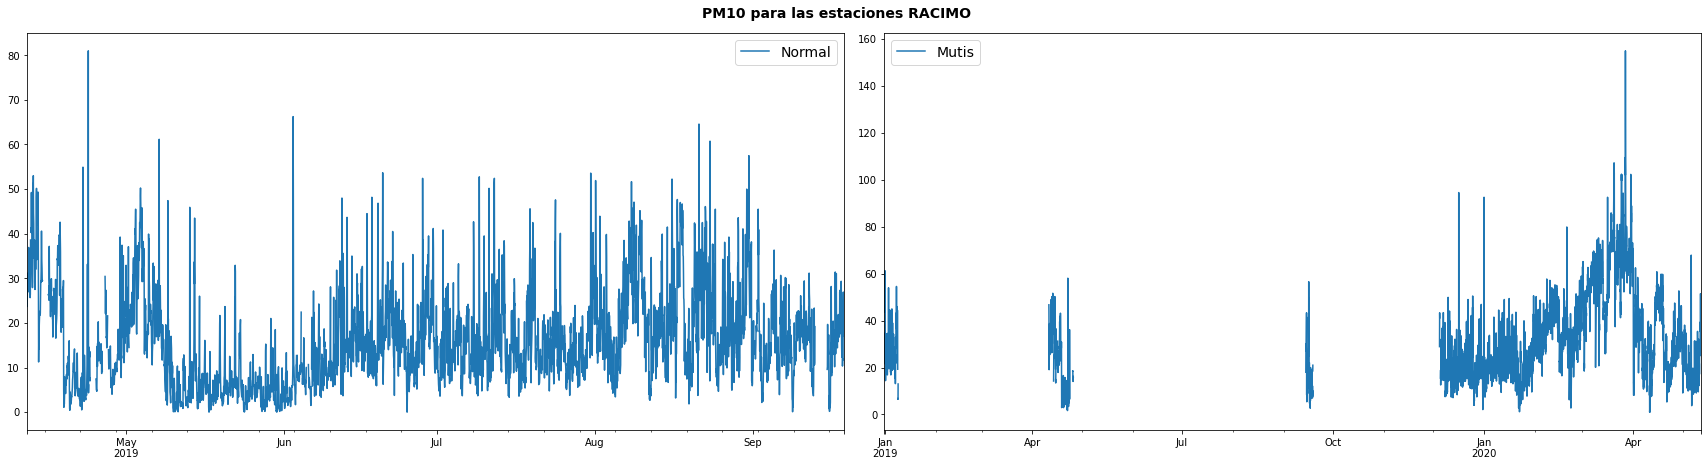

In [4]:
plt.figure(figsize = (30,6))
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.0,top = 0.92,wspace = 0.05,hspace = 0.2)
plt.suptitle("PM10 para las estaciones RACIMO",fontweight='bold',fontsize=14)
plt.subplot(1,2,1)
normal.pm10_a.plot(label = 'Normal')
plt.legend(fontsize = 14)
plt.subplot(1,2,2)
mutis.pm10_a.plot(label = 'Mutis')
plt.legend(fontsize = 14)

plt.show()

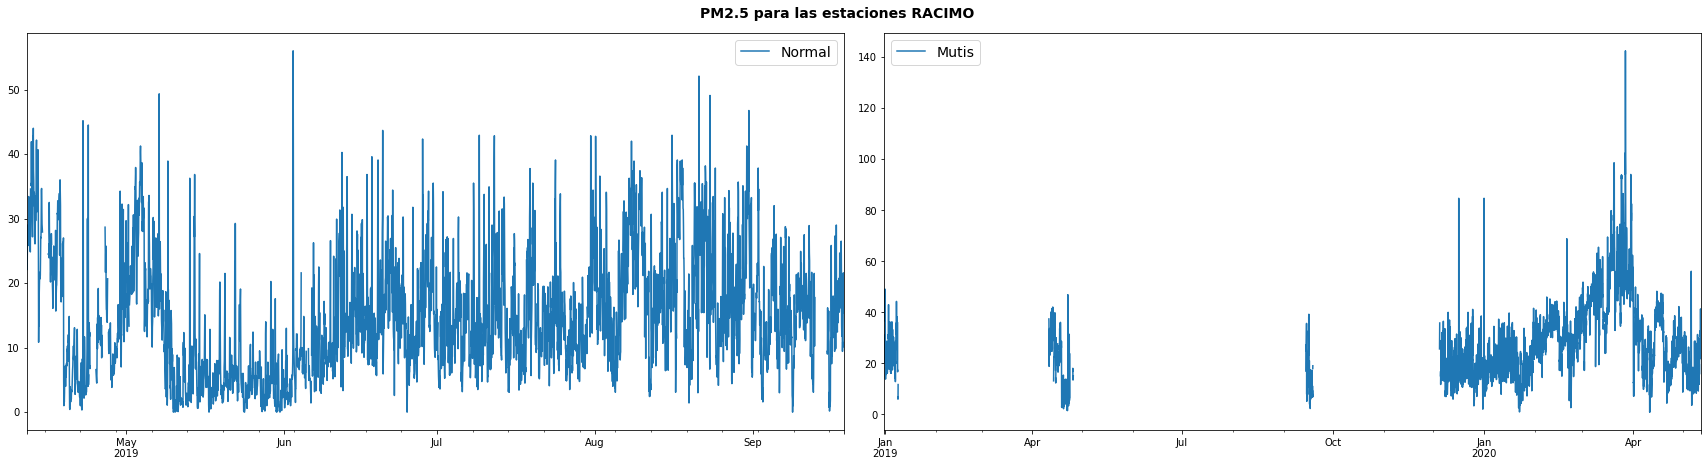

In [5]:
plt.figure(figsize = (30,6))
plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.0,top = 0.92,wspace = 0.05,hspace = 0.2)
plt.suptitle("PM2.5 para las estaciones RACIMO",fontweight='bold',fontsize=14)
plt.subplot(1,2,1)
normal.pm25_a.plot(label = 'Normal')
plt.legend(fontsize = 14)
plt.subplot(1,2,2)
mutis.pm25_a.plot(label = 'Mutis')
plt.legend(fontsize = 14)

De las gráficas anteriores se puede concluir que la estación **mutis** no es apropiada para realizar el análisis, por la poda disponibilidad de datos, por tanto el estudio se realizara utilizando los datos la estación **normal**

La data de la AMB contiene las siguientes variables:
- PM10 [$\mu g/m^3$]: material particulado
- PM2.5 [$\mu g/m^3$]:
- Temp_Aire [°C]: temperatura del aire
- Lluvia [mm]: 
- Humedad_relativa [%]: 
- WD [Grados]: Dirección del viento
- WS [m/s]: Velocidad del viento
- R_solar [$W/m^2$]: Radiación solar

In [6]:
# Cargar datos del AMB
normal_amb = load_amb_data("Data/amb_normal.xls")
normal_amb = normal_amb.dropna()

### Análisis de componentes principales

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Carga tus datos (reemplaza 'data.csv' con el nombre de tu archivo)
data = normal_amb

# Estandariza las variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Aplica PCA
pca = PCA()
pca.fit(scaled_data)



PCA()

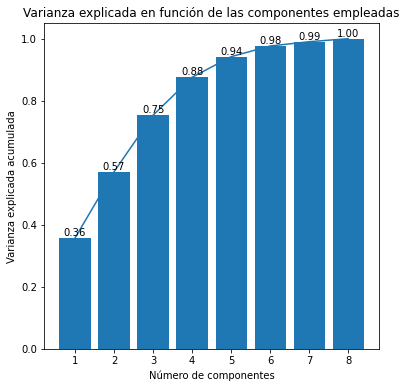

In [8]:
# Visualiza la varianza explicada en función de las componentes empleadas
plt.figure(figsize=(6,6))
num_components = np.arange(1, len(pca.explained_variance_ratio_) + 1)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Crea un gráfico de barras
bar_plot = plt.bar(num_components, cumulative_variance)
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))


# Agrega etiquetas sobre cada barra
for bar in bar_plot:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada en función de las componentes empleadas')
plt.show()


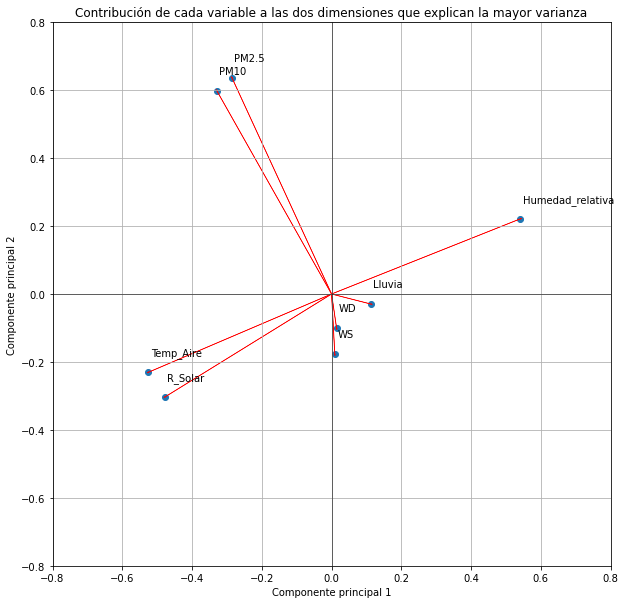

In [9]:
# Visualiza la contribución de cada variable a las dos dimensiones que explican la mayor varianza
loadings = pca.components_[:2].T
plt.figure(figsize=(10,10))
plt.scatter(loadings[:, 0], loadings[:, 1])

# Agrega un vector desde el origen hasta cada punto del scatter
for loading in loadings:
    plt.arrow(0, 0, loading[0], loading[1], color='red', lw=0.5)

# Mejora la ubicación del texto asociado a cada punto
offset = 0.007
for i, txt in enumerate(data.columns):
    plt.annotate(txt, (loadings[i, 0] + offset, loadings[i, 1] + 0.05))
    
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Contribución de cada variable a las dos dimensiones que explican la mayor varianza')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.ylim(-0.8,0.8)
plt.xlim(-0.8,0.8)
plt.grid()
plt.show()


### Comparación entre AMB y RACIMO

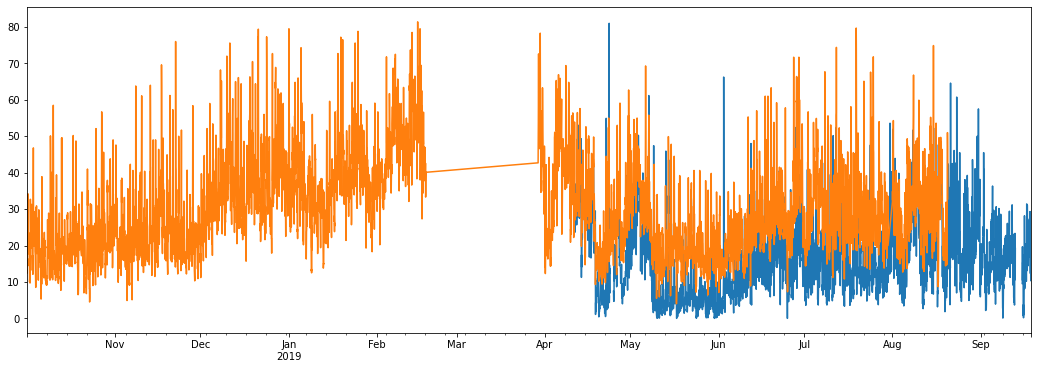

In [10]:
plt.figure(figsize = (18,6))
normal.pm10_a.plot()
normal_amb.PM10.plot()
plt.show()

In [11]:
# Unir las dos datas en una sola y dejar solo donde hay datos en las dos
data = pd.concat([normal_amb,normal],axis = 1).dropna()
# Suavisar los datos usando un filtro de mediana a las columnas de particulado
for column in data.columns:
    data[column] = medfilt(data[column],21)


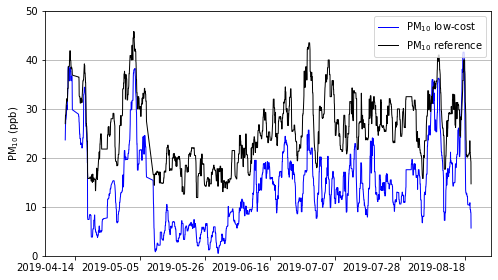

In [12]:
plt.figure(figsize = (8,5))
data.pm10_a.plot(label='PM$_{10}$ low-cost',lw=1,c='b')
data.PM10.plot(label='PM$_{10}$ reference',lw=1,c='k')
plt.legend()
plt.ylabel("PM$_{10}$ (ppb)")
plt.grid(axis='y')
plt.ylim(0,50)
plt.xticks(pd.date_range(start=data.index.min(), end=data.index.max(), freq='3W'),rotation=0)
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

#plt.savefig("pm10_normal_var.pdf",bbox_inches='tight',pad_inches=0)
plt.show()

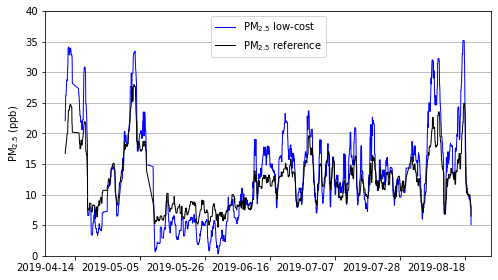

In [13]:
plt.figure(figsize=(8,5))
data.pm25_a.plot(label='PM$_{2.5}$ low-cost',lw=1,c='b')
data["PM2.5"].plot(label='PM$_{2.5}$ reference',lw=1,c='k')
plt.legend()
plt.ylabel("PM$_{2.5}$ (ppb)")
plt.grid(axis='y')
plt.ylim(0,40)
plt.xticks(pd.date_range(start=data.index.min(), end=data.index.max(), freq='3W'),rotation=0)
#plt.savefig("pm25_normal_var.pdf",bbox_inches='tight',pad_inches=0)
plt.show()

### Linear calibration model

In [14]:
# PM10
LR_pm10 = linear_calibration_model(data['pm10_a'],data['PM10'])
# PM2.5
LR_pm25 = linear_calibration_model(data['pm25_a'],data['PM2.5'])

In [15]:
print('Linear model - PM10')
LR_pm10

Linear model - PM10


{'RMSE': 3.654109632017997,
 'COEF': array([0.72560759]),
 'Intercept': 15.555633091513547,
 'r2_score': 0.6048455323151916,
 'correlation': 0.8509306997435897,
 'NRMSE': 0.06156977627467229}

In [16]:
print('Linear model - PM25')
LR_pm25

Linear model - PM25


{'RMSE': 1.4339699596654207,
 'COEF': array([0.57280949]),
 'Intercept': 4.630299166312537,
 'r2_score': 0.8837222383335305,
 'correlation': 0.946281984812753,
 'NRMSE': 0.04531984353144611}

### Multilinear calibration model

In [17]:
MLR_pm10 = linear_calibration_model(data[['pm10_a','t','p','h']],data['PM10'])
MLR_pm25 = linear_calibration_model(data[['pm25_a','t','p','h']],data['PM2.5'])

In [18]:
print('Multilinear model - PM10')
MLR_pm10

Multilinear model - PM10


{'RMSE': 3.2411592180059117,
 'COEF': array([ 0.75775803, -0.45886929, -0.25496921, -0.53872937]),
 'Intercept': 286.7773265291832,
 'r2_score': 0.7326261671840568,
 'correlation': 0.8897467084452182,
 'NRMSE': 0.0573507634915269}

In [19]:
print('Multilinear model - PM2.5')
MLR_pm25

Multilinear model - PM2.5


{'RMSE': 1.2020108299103704,
 'COEF': array([ 0.58634936, -0.09719381, -0.40429008, -0.16270414]),
 'Intercept': 380.3289447894756,
 'r2_score': 0.9244643514729125,
 'correlation': 0.9639197559454227,
 'NRMSE': 0.04244770362732312}

### Ramdom forest

In [25]:
# PM10
pm10_rf, RF_pm10 = random_forest_calibration( data[['pm10_a','t','p','h']], data['PM10'])
# PM2.5
pm25_rf, RF_pm25 = random_forest_calibration( data[['pm25_a','t','p','h']], data['PM2.5'])

In [26]:
print('Multilinear model - PM10')
RF_pm10

Multilinear model - PM10


{'RMSE': 1.5101409933452739,
 'r2_score': 0.9530755036369017,
 'correlation': 0.9775055154503188,
 'NRMSE': 0.02517306137829677,
 'accuracy': 95.72676608138424}

In [27]:
print('Multilinear model - PM2.5')
RF_pm25

Multilinear model - PM2.5


{'RMSE': 0.8523767595158523,
 'r2_score': 0.9650996506075141,
 'correlation': 0.9827380341230089,
 'NRMSE': 0.026408759324472633,
 'accuracy': 95.74693832407296}

In [28]:
LR_pm10.keys()

dict_keys(['RMSE', 'COEF', 'Intercept', 'r2_score', 'correlation', 'NRMSE'])

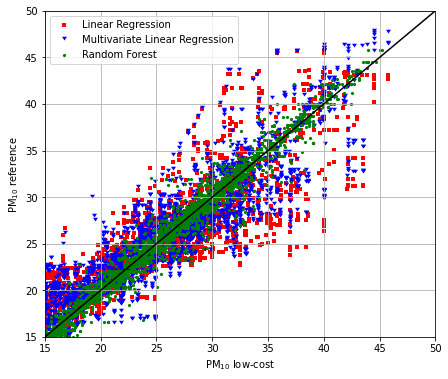

In [29]:
plt.figure(figsize=(7,6))

plt.scatter(data["PM10"],data["pm10_a"]*LR_pm10['COEF'][0] + LR_pm10['Intercept'], label='Linear Regression',lw=0.01,marker='s',alpha=1,c='r',s=10)
plt.scatter(data["PM10"],data["pm10_a"]*MLR_pm10['COEF'][0]+
            data["t"]*MLR_pm10['COEF'][1]+
            data["p"]*MLR_pm10['COEF'][2]+
            data["h"]*MLR_pm10['COEF'][3]+
            MLR_pm10['Intercept'],label='Multivariate Linear Regression',lw=0.01,marker=7,alpha=1,c='b',s=25)
plt.scatter(pm10_rf,data["PM10"],label='Random Forest',lw=0.01,marker='o',alpha=1,c='g',s=10) 
x=np.linspace(15,100,10)
plt.plot(x,x,'k-')
plt.ylabel("PM$_{10}$ reference")
plt.xlabel("PM$_{10}$ low-cost")
plt.ylim(15,50)
plt.xlim(15,50)
plt.grid()
plt.legend()
#plt.savefig("pm10_normal_method.pdf",bbox_inches='tight',pad_inches=0)
plt.show()

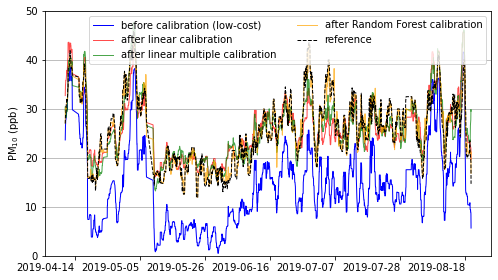

In [36]:
plt.figure(figsize=(8,5))
data["pm10_a"].plot(label="before calibration (low-cost)",lw=1,c='b')

plt.plot(data.index,data["pm10_a"]*LR_pm10['COEF'][0] + LR_pm10['Intercept'],
         label='after linear calibration',lw=1,c='r',linestyle='-',alpha=0.7)
plt.plot(data.index,data["pm10_a"]*MLR_pm10['COEF'][0]+
            data["t"]*MLR_pm10['COEF'][1]+
            data["p"]*MLR_pm10['COEF'][2]+
            data["h"]*MLR_pm10['COEF'][3]+
            MLR_pm10['Intercept'],label='after linear multiple calibration',lw=1,c='g',linestyle='-',alpha=0.7)
plt.plot(data.index,pm10_rf,label='after Random Forest calibration',lw=1,c='orange',linestyle='-',alpha=0.7)
data["PM10"].plot(label="reference",lw=1,c='k',linestyle='--')
plt.ylim(0,50)
plt.legend(ncol=2)
plt.ylabel("PM$_{10}$ (ppb)")
plt.grid(axis='y')
plt.xticks(pd.date_range(start=data.index.min(), end = data.index.max(), freq='3W'),rotation=0)
#plt.savefig("pm10_normal_allcalib.pdf",bbox_inches='tight',pad_inches=0)
plt.show()